epoch: 1 step: 1, loss is 0.6659393310546875
acc is: 0.2857142857142857
epoch: 1 step: 2, loss is 0.7609612345695496
acc is: 0.2857142857142857
epoch: 1 step: 3, loss is 0.7033388018608093
[WARNING] DEBUG(62520,7fee3a804740,python):2022-06-19-09:51:58.639.460 [mindspore/ccsrc/debug/debugger/debugger.cc:95] Debugger] Not enabling debugger. Debugger does not support CPU.
acc is: 0.3333333333333333
epoch: 1 step: 4, loss is 0.7305893898010254
acc is: 0.38095238095238093
epoch: 1 step: 5, loss is 0.7380430102348328
acc is: 0.38095238095238093
epoch: 1 step: 6, loss is 0.7031256556510925
acc is: 0.38095238095238093
epoch: 1 step: 7, loss is 0.692492663860321
acc is: 0.38095238095238093
epoch: 1 step: 8, loss is 0.6707430481910706
acc is: 0.38095238095238093
epoch: 1 step: 9, loss is 0.7229869961738586
acc is: 0.38095238095238093
epoch: 1 step: 10, loss is 0.7627434730529785
acc is: 0.38095238095238093
epoch: 1 step: 11, loss is 0.6846277713775635
acc is: 0.38095238095238093
epoch: 1 step: 1

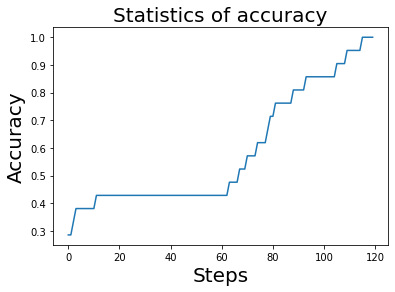

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 13 17:01:29 2022

@author: Waikikilick
"""

import os
import sys
import numpy as np
import mindspore as ms
from mindquantum import *
import mindspore.dataset as ds
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '2'
import mindspore.context as context
from mindspore import Model, load_checkpoint
from mindspore.nn import Adam, Accuracy, SoftmaxCrossEntropyWithLogits     
from mindspore.train.callback import Callback, LossMonitor, ModelCheckpoint, CheckpointConfig

ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU") # 训练模式 和 上下文管理器
ms.set_seed(1) # 随机数种子
np.random.seed(1) 

class Main():
    def __init__(self, batch_size=3): # 定义训练中的批数据大小
        super().__init__()
        # 导入数据集
        self.train_x = np.load('./src/4_train_x.npy', allow_pickle=True)
        self.train_y = np.load('./src/4_train_y.npy', allow_pickle=True)
        self.eval_x = np.load('./src/4_eval_x.npy', allow_pickle=True)
        self.eval_y = np.load('./src/4_eval_y.npy', allow_pickle=True)
        self.batch_size = batch_size # 批大小
        self.train_dataset = self.build_dataset(self.train_x, self.train_y, self.batch_size) # 构建训练集
        self.eval_dataset = self.build_dataset(self.eval_x, self.eval_y, 21) # 构建验证集
        self.qnet = MQLayer(self.build_grad_ops()) # 封装网络
        self.model = self.build_model() # 建立总模型
        self.checkpoint_name = "./model.ckpt" # 待保存模型的名字
        
    def build_dataset(self, x, y, batch=None):
        train = ds.NumpySlicesDataset(
            {  "image": x.reshape((x.shape[0], -1)),
                "label": y.astype(np.int32)
            }, shuffle=False) # 因为数据集本来就是随机分布的，所以不用再打乱
        if batch is not None:
            train = train.batch(batch)
        return train

    def build_grad_ops(self):
        # 构建编码线路
        qubit_num = 4
        encoder = Circuit()
        for i in range(qubit_num):
            encoder += H.on(i)
        encoder += BarrierGate()

        for i in range(qubit_num-1):
            encoder += ZZ(f'{0}').on([i, i+1])
        encoder += ZZ(f'{0}').on([qubit_num-1, 0])
        encoder += BarrierGate()

        for i in range(qubit_num):
            encoder += RX(f'{1}').on(i)
        encoder += BarrierGate()

        for i in range(qubit_num-1):
            encoder += ZZ(f'{2}').on([i, i+1])
        encoder += ZZ(f'{2}').on([qubit_num-1, 0])
        encoder += BarrierGate()

        for i in range(qubit_num):
            encoder += RX(f'{3}').on(i)
        encoder += BarrierGate()
        encoder.no_grad() # 编码线路不参与训练
        
        # 构建拟设线路
        ansatz = Circuit()
        ansatz += conv_circ('00',0,1)
        ansatz += conv_circ('01',2,3)
        ansatz += pool_circ('02',0,1)
        ansatz += pool_circ('03',3,2)

        ansatz += conv_circ('10',1,2)
        ansatz += pool_circ('11',1,2)
        
        total_circ = encoder + ansatz # 总线路为 编码线路 + 拟设线路

        ham = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [1,2]] # 通过测量第 1,2 个比特的测量值来定义分类结果
        sim = Simulator('mqvector', total_circ.n_qubits) # 定义模拟器
        
        grad_ops = sim.get_expectation_with_grad( # 梯度和期望值计算接口
            ham,
            total_circ,
            encoder_params_name=encoder.params_name,
            ansatz_params_name=ansatz.params_name,
            parallel_worker=5)
        return grad_ops

    def build_model(self):
        self.loss = ms.nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean') # 采用交叉熵损失函数
        self.opti = ms.nn.Adam(self.qnet.trainable_params()) # 采用 Adam 优化器
        self.model = Model(self.qnet, self.loss, self.opti, metrics={'Acc': Accuracy()}) # 装配模型
        return self.model

    def train(self, epoch=1): # 训练过程中，每一步都计算一次模型对验证集的预测准确度
        self.model.train(epoch, self.train_dataset, callbacks=[LossMonitor(1), acc, ckpoint_cb], dataset_sink_mode=False)

    def export_trained_parameters(self): # 输出此时的模型
        qnet_weight = self.qnet.weight.asnumpy()
        ms.save_checkpoint(self.qnet, self.checkpoint_name)

    def load_trained_parameters(self): # 导入指定的模型
        ms.load_param_into_net(self.qnet,
                               ms.load_checkpoint(self.checkpoint_name))
        
    def load_training_ckpoint(self, ckpoint_name): # 导入训练过程中的某个模型
        ms.load_param_into_net(self.qnet,
                               ms.load_checkpoint(ckpoint_name))

    def predict(self, origin_test_x) -> float: # 用于预测
        test_x = origin_test_x.reshape((origin_test_x.shape[0], -1))
        predict = self.model.predict(ms.Tensor(test_x))
        predict = predict.asnumpy().flatten() > 0
        return predict
    
    
def conv_circ(prefix='0', bit_up=0, bit_down=1): # 定义卷积核
    _circ = Circuit()
    _circ += RX('00').on(bit_up)
    _circ += RY('01').on(bit_up)
    _circ += RZ('02').on(bit_up)
    _circ += RX('03').on(bit_down)
    _circ += RY('04').on(bit_down)
    _circ += RZ('05').on(bit_down)

    _circ += ZZ('06').on([bit_up, bit_down])
    _circ += YY('07').on([bit_up, bit_down])
    _circ += XX('08').on([bit_up, bit_down])

    _circ += RX('09').on(bit_up)
    _circ += RY('10').on(bit_up)
    _circ += RZ('11').on(bit_up)
    _circ += RX('12').on(bit_down)
    _circ += RY('13').on(bit_down)
    _circ += RZ('14').on(bit_down)
    _circ = add_prefix(_circ, prefix)
    return _circ

def pool_circ(prefix='0', bit_up=0, bit_down=1): # 定义池化操作
    _circ = Circuit()
    _circ += RX('00').on(bit_up)
    _circ += RY('01').on(bit_up)
    _circ += RZ('02').on(bit_up)
    _circ += RX('03').on(bit_down)
    _circ += RY('04').on(bit_down)
    _circ += RZ('05').on(bit_down)

    _circ += X.on(bit_down, bit_up)
    
    _circ += RX('06').on(bit_down)
    _circ += RY('07').on(bit_down)
    _circ += RZ('08').on(bit_down)
    _circ = add_prefix(_circ, prefix)
    return _circ

class StepAcc(Callback):  # 定义一个关于每一步准确率的回调函数
    def __init__(self, model):
        self.model = model
        self.acc = []

    def step_end(self, run_context):
        acc_tem = self.model.eval(main.eval_dataset, dataset_sink_mode=False)['Acc']
        print('acc is:', acc_tem) #, 'lr is:', main.opti.get_lr()[0])
        self.acc.append(acc_tem)
        
if __name__ == '__main__':
    
    main = Main()
    main.ckpoint_file = './ckpoint_file'
    
    acc = StepAcc(main.model)  
    config_ck = CheckpointConfig(save_checkpoint_steps=1, keep_checkpoint_max=100000000, exception_save=True)
    ckpoint_cb = ModelCheckpoint(prefix='9b', directory=main.ckpoint_file, config=config_ck)
    sys.stdout.flush()
    epoch =  6
    lr = 0.01
    main.opti = ms.nn.Adam(main.qnet.trainable_params(), lr)
    main.train(epoch) # 训练
    print(acc.acc) # 输出训练过程中，验证集分类准确度记录

    plt.figure()
    plt.plot(acc.acc) # 画出训练过程中，验证集分类准确度的变化情况
    plt.title('Statistics of accuracy', fontsize=20)
    plt.xlabel('Steps', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    plt.savefig('./src/result_4_qubit.png')
    plt.show()
    